# Analyze Knee MRIs with Python 🚑

In this project, we will specifically focus on Anterior Cruciate Ligament (ACL) tears which are the most common knee injuries among top athletes in soccer or basketball.

ACL tears happen when the anterior cruciate ligament is either stretched, partially torn, or completely torn. The most common injury is a complete tear.

Symptoms include pain, a popping sound during injury, instability of the knee, and joint swelling, There are around 200,000 ACL tears each year in the United States, with over 100,000 ACL reconstruction surgeries per year.

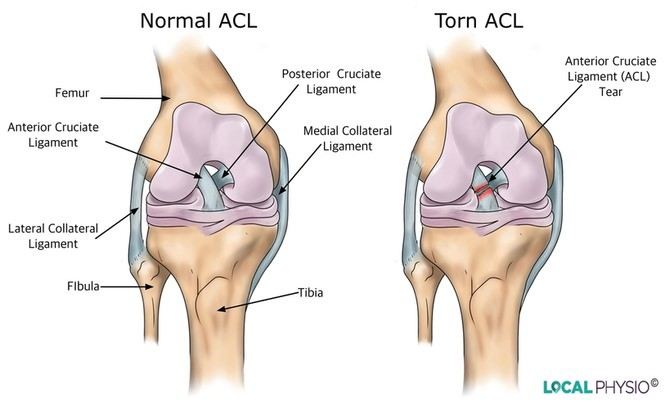

## Magnetic Resonance Imaging

Magnetic Resonance Imaging (MRI) is a medical imaging technique used in radiology to form a picture of the anatomy and the physiological processes of the body.

MRI is used to diagnose how well you responded to treatment as well as detecting tears and structural problems such as heart attacks, brain injury, blood vessel damage, etc.

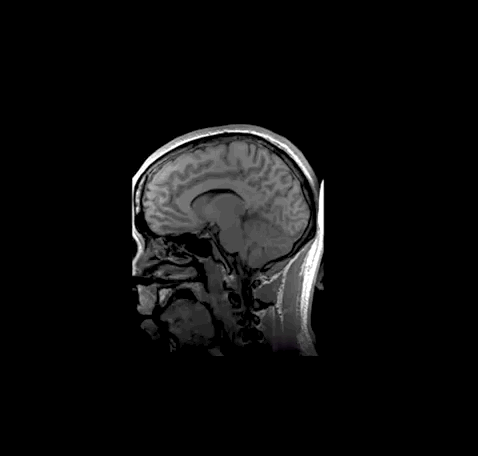

MRNet dataset
MRNet is a knee MRI dataset provided by Andrew Ng’s Stanford lab.

It’s split in training set (1130 cases), validation set (120 cases) and test set (120 cases) and is organized as follows:

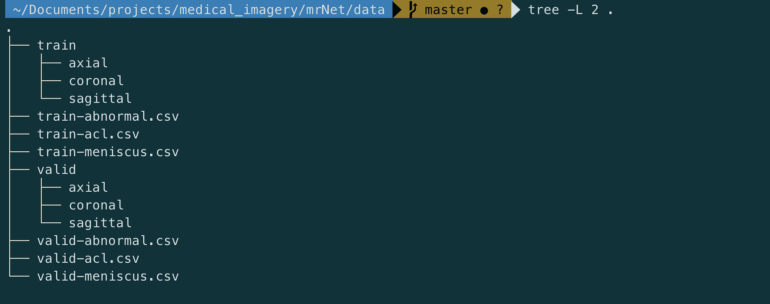

Each case, in both train and valid folder, has 3 MRI scans taken from different planes: sagittal, coronal and axial.

To make a proper decision regarding a case, the radiologist usually looks at MRI scans from different planes to have a global view.

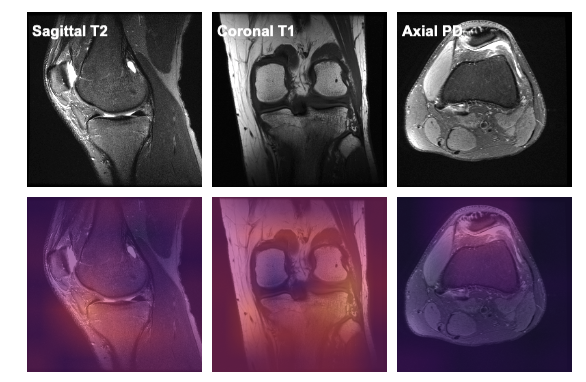

The CSV files train-acl.csv and valid-acl.csv have the same structure with two columns:

* Case: the id of the case
* Abnormal: a binary value (1/0) indicate the ACL tear

In [1]:
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi=False

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook


train_acl = pd.read_csv('../input/mrnet-v1/MRNet-v1.0/train-acl.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})

train_acl.head()

,Case,Abnormal
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


In [2]:
# ACL tears appear in less than 20% of the cases for the training set.
train_acl.shape # (1130, 2)
train_acl.Abnormal.value_counts(normalize=True)

0    0.815929
1    0.184071
Name: Abnormal, dtype: float64

Let’s look at a given case from the 3-plane perspective

Each MRI scan is a tensor of s slices. Each slice is a grayscale image of size (256, 256).

In [3]:
case = '0000'

mri_coronal = np.load('../input/mrnet-v1/MRNet-v1.0/train/coronal/0000.npy')
mri_axial = np.load('../input/mrnet-v1/MRNet-v1.0/train/axial/0000.npy')
mri_sagittal = np.load('../input/mrnet-v1/MRNet-v1.0/train/sagittal/0000.npy')

# (slice or channel, width, hight)
print(f'MRI scan on coronal plane: {mri_coronal.shape}')
print(f'MRI scan on axial plane: {mri_axial.shape}')
print(f'MRI scan on sagittal plane: {mri_sagittal.shape}')

MRI scan on coronal plane: (36, 256, 256)
MRI scan on axial plane: (44, 256, 256)
MRI scan on sagittal plane: (36, 256, 256)


Let’s visualize the first one on each plane

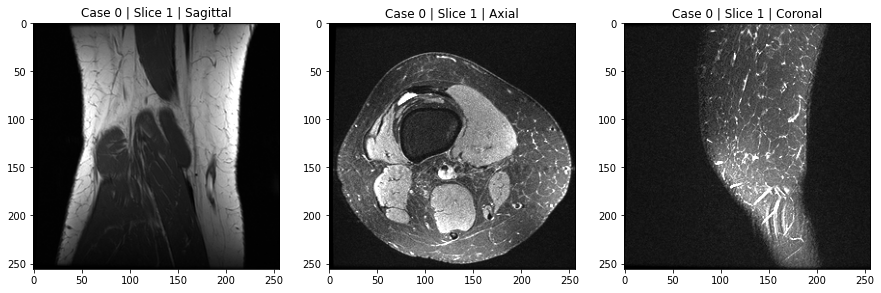

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(mri_coronal[0, :, :], 'gray');
ax1.set_title('Case 0 | Slice 1 | Sagittal');

ax2.imshow(mri_axial[0, :, :], 'gray');
ax2.set_title('Case 0 | Slice 1 | Axial');

ax3.imshow(mri_sagittal[0, :, :], 'gray');
ax3.set_title('Case 0 | Slice 1 | Coronal');

It’s not very convenient to plot slices of MRI scans and have a global view between three different planes, especially when you have a large number of slices per MRI scan and need to go over each slice.

So here’s how we can turn a static matplolib plot into an interactive widget that allows you to:

* Select a case
* Slide over the slices per plane
* See the plots dynamically change

Let’s see how this can be done:

You first need to load your data in a convenient dictionary where the keys are case numbers and the values are dictionaries in which keys are planes and the corresponding values are NumPy arrays representing the MRI scan. **A nested dictionary.**

In [5]:
train_path = '../input/mrnet-v1/MRNet-v1.0/train'

def load_one_stack(case, data_path=train_path, plane='coronal'):
    '''
    Load one case plane by the arrangement of it's path name and plane.
    '''
    fpath = '{}/{}/{}.npy'.format(data_path, plane, case)
    return np.load(fpath)

def load_stacks(case, data_path=train_path):
    '''
    Load the 3 planes of a case and store them in a dictionary.
    '''
    x = {}
    planes = ['coronal', 'sagittal', 'axial']
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, plane=plane) # keys are planes and the corresponding values are NumPy arrays representing the MRI scan.
    return x

def load_cases(train=True, n=None):
    '''
    Read cases numbers then create and return the nested dictionary.
    '''
    assert (type(n) == int) and (n < 1250)
    
    # Read cases numbers from the dataset.
    if train:
        case_list = pd.read_csv('../input/mrnet-v1/MRNet-v1.0/train-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    else:
        case_list = pd.read_csv('../input/mrnet-v1/MRNet-v1.0/valid-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    cases = {}
    
    if n is not None:
        case_list = case_list[:n] # read just n of cases
        
    for case in tqdm_notebook(case_list):
        x = load_stacks(case)
        cases[case] = x # convenient dictionary where the keys are case numbers and the values are dictionaries in which keys are planes and the corresponding values are NumPy arrays representing the MRI scan.
    return cases

cases = load_cases(n=100) # create the nested dictionary.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
# After loading 100 cases, let’s look a the case 0000
cases['0000'].keys()

dict_keys(['coronal', 'sagittal', 'axial'])

As expected, it contains a nested dictionary that maps plane to NumPy array objects.

In [7]:
# (slice or channel, width, hight)
print(cases['0000']['axial'].shape)
print(cases['0000']['coronal'].shape)
print(cases['0000']['sagittal'].shape)

(44, 256, 256)
(36, 256, 256)
(36, 256, 256)


Now we define a class called KneePlot that creates the interactive plot from the cases object.

This class defines:

* an abstract method plot_slices that plots three slices of a given case. This method is automatically called each time an interaction is done on the widgets
* a draw method responsible for defining the dropdown and slider widgets that fetch the user input data and pass them to the plot_slices interactively.

In [8]:
class KneePlot():
    def __init__(self, cases, figsize=(15, 5)):
        self.cases = cases
        
        self.planes = {case: ['coronal', 'sagittal', 'axial'] for case in self.cases}
        
        # get number of the slices of a case
        self.slice_nums = {}
        for case in self.cases:
            self.slice_nums[case] = {}
            for plane in ['coronal', 'sagittal', 'axial']:
                self.slice_nums[case][plane] = self.cases[case][plane].shape[0] # (44, 256, 256), (slice or channel, width, hight)

        self.figsize = figsize
        
    def _plot_slices(self, case, im_slice_coronal, im_slice_sagittal, im_slice_axial):
        '''
        Receive case planes slices and plot them.
        '''
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=self.figsize)
        
        ax1.imshow(self.cases[case]['coronal'][im_slice_coronal, :, :], 'gray')
        ax1.set_title(f'MRI slice {im_slice_coronal} on coronal plane')
        
        ax2.imshow(self.cases[case]['sagittal'][im_slice_sagittal, :, :], 'gray')
        ax2.set_title(f'MRI slice {im_slice_sagittal} on sagittal plane')
        
        ax3.imshow(self.cases[case]['axial'][im_slice_axial, :, :], 'gray')
        ax3.set_title(f'MRI slice {im_slice_axial} on axial plane')
        
        plt.show()
    
    def draw(self):
        '''
        Defining the dropdown and slider widgets that fetch the user input data and pass them to the plot_slices interactively.
        '''
        case_widget = Dropdown(options=list(self.cases.keys()),
                               description='Case'
                              
                              )
        case_init = list(self.cases.keys())[0]


        slice_init_coronal = self.slice_nums[case_init]['coronal'] - 1        
        slices_widget_coronal = IntSlider(min=0, 
                                          max=slice_init_coronal, 
                                          value=slice_init_coronal // 2, 
                                          description='Coronal')
        
        slice_init_sagittal = self.slice_nums[case_init]['sagittal'] - 1        
        slices_widget_sagittal = IntSlider(min=0,
                                           max=slice_init_sagittal,
                                           value=slice_init_sagittal // 2,
                                           description='Sagittal'
                                          )
        
        slice_init_axial = self.slice_nums[case_init]['axial'] - 1        
        slices_widget_axial = IntSlider(min=0,
                                        max=slice_init_axial,
                                        value=slice_init_axial // 2,
                                        description='Axial'
                                       )
        
        def update_slices_widget(*args):
            slices_widget_coronal.max = self.slice_nums[case_widget.value]['coronal'] - 1
            slices_widget_coronal.value = slices_widget_coronal.max // 2
            
            slices_widget_sagittal.max = self.slice_nums[case_widget.value]['sagittal'] - 1
            slices_widget_sagittal.value = slices_widget_sagittal.max // 2
            
            slices_widget_axial.max = self.slice_nums[case_widget.value]['axial'] - 1
            slices_widget_axial.value = slices_widget_axial.max // 2
    
        
        case_widget.observe(update_slices_widget, 'value')
        interact(self._plot_slices,
                 case=case_widget, 
                 im_slice_coronal=slices_widget_coronal, 
                 im_slice_sagittal=slices_widget_sagittal, 
                 im_slice_axial=slices_widget_axial
                )
    
    def resize(self, figsize): 
        self.figsize = figsize

In [9]:
plot = KneePlot(cases)
plot.draw()

interactive(children=(Dropdown(description='Case', options=('0000', '0001', '0002', '0003', '0004', '0005', '0…